In [ ]:
# import libraries
import os
os.system('pip install swifter')
os.system('pip install pyunpack')
os.system('pip install patool')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyunpack import Archive
import swifter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, vstack,hstack
import re
import array
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.feature_extraction.text import _make_int_array, CountVectorizer
from scipy import sparse as sp
import multiprocessing as mp
import pickle
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MaxAbsScaler
import scipy.sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")


In [ ]:
def func_extract_zip(in_path,out_path):
    #ref - https://www.kaggle.com/general/129520
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    Archive(in_path).extractall(out_path)

In [ ]:
func_extract_zip('/content/drive/My Drive/AAIC/CS/Data/train.tsv.7z','/content/')

In [ ]:
#read the file
df = pd.read_csv('train.tsv',sep='\t')

In [ ]:
#view top 5 rows pf file
df.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## **EDA**

In [ ]:
#understand each columns datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [ ]:
#find NA/null values in data
df.isna().sum()
#we can see there is need of data imputation as there are many NULL/NA values

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [ ]:
def imputation(data):
    """
    Fill the missing values
    """
    data.category_name.fillna(value = "other/other/other", inplace = True)
    data.brand_name.fillna(value = "unknown", inplace = True)
    data.item_description.fillna(value = "no_description", inplace = True)
    return data

train = imputation(df)


In [ ]:
train.isna().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [ ]:
#max price of item in dataset
max(train['price'])

2009.0

In [ ]:
#minimum price of item in dataset
min(train['price'])

0.0

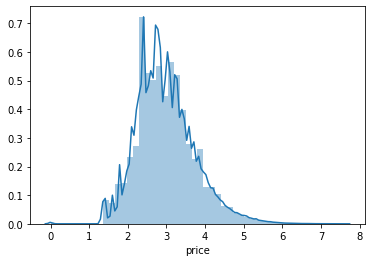

In [ ]:
# histogram of log(price+1)
sns.distplot(np.log(train['price']+1))

#by below chart we can see that log prices are somewhat centered around 2 and 3

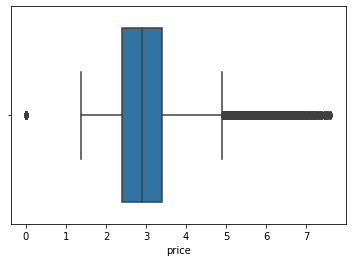

In [ ]:
#below box plot gives us understanding that 50% of log prices are between 2.5-3.5
sns.boxplot(np.log(train['price']+1))

In [ ]:
print("There are", train[train["price"] == 0].price.size, "items with price 0.")

There are 874 items with price 0.


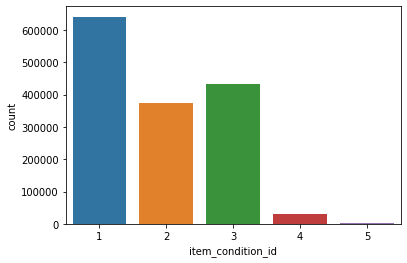

In [ ]:
#number of items according to item condition 
sns.countplot(x="item_condition_id", data=train)

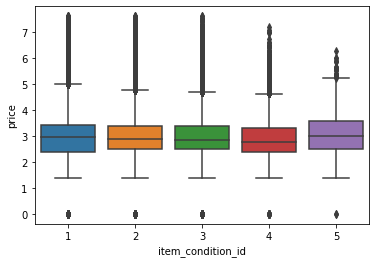

In [ ]:
#Percentile price distribution according to item condition
sns.boxplot(x="item_condition_id", y=np.log(train['price']+1), data=train)

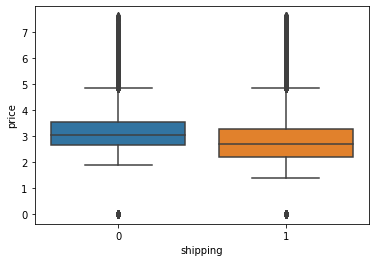

In [ ]:
#Here we can see opposite of what was expected. Prodctus  were shipping is free have lower prices than were shipping is not free.
sns.boxplot(x="shipping", y=np.log(df['price']+1), data=df)

In [ ]:
brand = train["brand_name"].value_counts()
print("There are", brands.size, "unique known brands.")

There are 4810 unique known brands.


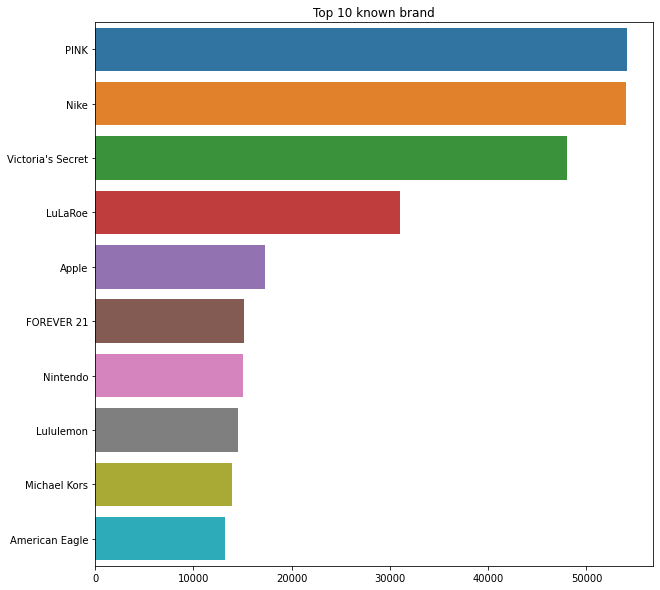

In [ ]:
#Top 10 Brands and count of items beloging to that brand
plt.figure(figsize = (10, 10))
sns.barplot(brand[1:11].values, brand[1:11].index)
plt.title("Top 10 known brand")
plt.show()

In [ ]:
# we can use all this stats on brand column  as one of featuers in our feature list
brand_std_price = train.groupby(["brand_name"], as_index = True).price.std().sort_values(ascending = False)
print("std price by brands", brand_std_price[:10])
brand_mean_price = train.groupby(["brand_name"], as_index = True).price.mean().sort_values(ascending = False)
print("mean price by brands", brand_mean_price[:10])
brand_median_price = train.groupby(["brand_name"]).price.median().sort_values(ascending = False)
print("median price by brands", brand_median_price[:10])

std price by brands brand_name
Demdaco               592.555483
Proenza Schouler      420.369183
MCM Worldwide         351.470773
Saint Laurent         339.769830
Celine                339.356795
Louis Vuitton         247.801644
Goyard                242.051339
Sanyo                 226.328216
MICHELE               224.704134
Valentino Garavani    222.253909
Name: price, dtype: float64
mean price by brands brand_name
Demdaco             429.000000
Proenza Schouler    413.250000
Auto Meter          344.000000
Oris                300.000000
MCM Worldwide       289.173913
Longines            254.000000
Vitamix             253.111111
Blendtec            251.800000
David Yurman        248.611570
Celine              238.780822
Name: price, dtype: float64
median price by brands brand_name
Demdaco                429.0
Auto Meter             344.0
Proenza Schouler       315.5
Oris                   300.0
Longines               254.0
Blendtec               250.0
Dainese                230.0
Fréd

In [ ]:
#https://www.kaggle.com/konohayui/mercari-price-suggestion-eda

train["main_cat"] = train.category_name.str.extract("([^/]+)/[^/]+/[^/]+")
train["subcat1"] = train.category_name.str.extract("[^/]+/([^/]+)/[^/]+")
train["subcat2"] = train.category_name.str.extract("[^/]+/[^/]+/([^/]+)")
train['log_price'] = np.log(train['price']+1)

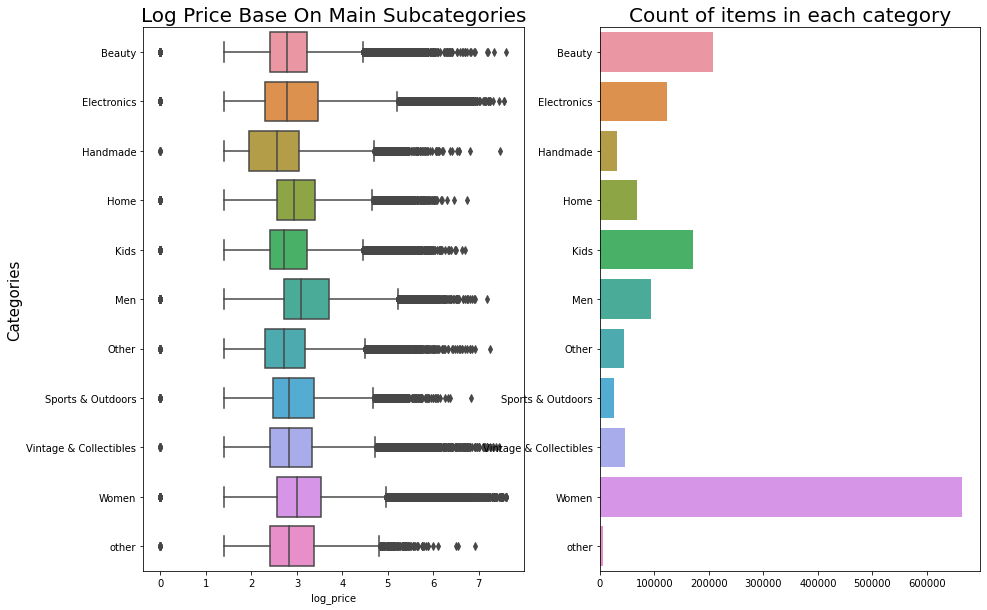

In [ ]:
# we can add quantile price of each subcategory as a featuer
category = train.main_cat
order = sorted(category.unique())
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
sns.boxplot(x = train.log_price, y = category, orient = "h", order = order, ax = ax[0])
ax[0].set_title("Log Price Base On Main Subcategories", fontsize = 20)
ax[0].set_ylabel("Categories", fontsize = 15)
sns.barplot(category.value_counts().values, category.value_counts().index, order = order, ax = ax[1])
ax[1].set_title("Count of items in each category", fontsize = 20)
plt.show()

## **Pre-processing**


In [ ]:
df = imputation(df)
df = df[(df.price >= 3) & (df.price <= 2000)]
y = df['price']
X = df.drop(['price'], axis = 1)



In [ ]:
#split data into train tes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# pre-process shipping

def pre_shipping(df):
  """
  This function takes df as input and converts shipping column into csr matrix and returns that
  i/p= Whole Dataframe
  o/p= Shipping coloumn in csr matrix format
  o/p shape = (?,1)
  """
  shipping = np.array(df['shipping'])
  shipping = shipping.reshape(-1,1)
  shipping = csr_matrix(shipping)

  return shipping


X_train_shipping = pre_shipping(X_train)
X_test_shipping =  pre_shipping(X_test)
X_train_shipping.shape, X_test_shipping.shape

((1111243, 1), (370415, 1))

In [ ]:
# item_condition_id 

def pre_item_condition_id(df,vectorizer=None,train=True):
  """
  This function is to pre-process item_condition_id column. We apply One hot encoding on item_condition_id column
  i/p= whole Dataframe
  o/p = OneHotEncoded csr matrix of item_condition_id column
  o/p shape = (?,5)
  """
  if train==True:
    item_condition = np.array(df['item_condition_id']).reshape(-1,1)
    item_condition_vec = OneHotEncoder()
    item_condition_vec.fit(item_condition)
    item_condition = csr_matrix(item_condition_vec.transform(item_condition))

    return item_condition,item_condition_vec
  else:
    item_condition = np.array(df['item_condition_id']).reshape(-1,1)
    item_condition = csr_matrix(vectorizer.transform(item_condition))
    return item_condition


X_train_item_condition,item_condition_vec  = pre_item_condition_id(X_train)

pkl_filename = '/content/drive/My Drive/AAIC/CS/item_condition_vec.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(item_condition_vec,file)

with open(pkl_filename, 'rb') as file:
    item_condition_vec = pickle.load(file)

X_test_item_condition = pre_item_condition_id(X_test,item_condition_vec,train=False)
X_train_item_condition.shape,X_test_item_condition.shape

((1111243, 5), (370415, 5))

In [ ]:
#pre-process category_name

def pre_cat(df,main_cat_vec=None,subcat1_vec=None,subcat2_vec=None,training=True):
  """
  This function does the pre-processing of category_name variable. We first split this variable into 3 parts main category, sub category1 and subcategory 2
  One this new 3 columns One Hot encoding is appiled. Then all 3 a combined together and returend as output.
  df = Whole datfarme 
  main_cat_vec = Vectorizer for main category required during test time
  subcat1_vec =  Vectorizer for sub category1 required during test time
  subcat2_vec =  Vectorizer for sub category2 required during test time
  o/p = csr matrix of One hot encodeding of all 3 coloumn
  o/p shape = (?,973)
  """

  def pre_cat_name(x):
    """
    This function is used to pre-process the text.
    """
    x = str(x).lower()
    x = re.sub('[^A-Za-z0-9]+', ' ', x)
    x = re.sub(' +', ' ', x)
    x = x.replace(' ','_')
    return x

  def pre_item_condition_id(df,vectorizer=None,training=True):
    """
    This function returns the onehot encoded featuers.
    """
    if training==True:
      item_condition = df
      item_condition_vec = CountVectorizer(lowercase=False)
      item_condition_vec.fit(item_condition)
      item_condition = csr_matrix(item_condition_vec.transform(item_condition))

      return item_condition,item_condition_vec
    else:
      item_condition = df
      item_condition = csr_matrix(vectorizer.transform(item_condition))
      return item_condition

  train = df
  train["main_cat"] = train.category_name.str.extract("([^/]+)/[^/]+/[^/]+")
  train["subcat1"] = train.category_name.str.extract("[^/]+/([^/]+)/[^/]+")
  train["subcat2"] = train.category_name.str.extract("[^/]+/[^/]+/([^/]+)")
  train["main_cat"]  = train["main_cat"].apply(pre_cat_name)
  train["subcat1"]  = train["subcat1"].apply(pre_cat_name)
  train["subcat2"]  = train["subcat2"].apply(pre_cat_name)

  if training==True:
    main_cat, main_cat_vec  = pre_item_condition_id(train["main_cat"] )
    subcat1,subcat1_vec = pre_item_condition_id(train["subcat1"] )
    subcat2,subcat2_vec = pre_item_condition_id(train["subcat2"] )
    cat = hstack([main_cat,subcat1,subcat2])

    return cat,main_cat_vec,subcat1_vec,subcat2_vec
  else:
    main_cat  = pre_item_condition_id(train["main_cat"],main_cat_vec,training )
    subcat1 = pre_item_condition_id(train["subcat1"] ,subcat1_vec,training)
    subcat2 = pre_item_condition_id(train["subcat2"] ,subcat2_vec,training)
    cat = hstack([main_cat,subcat1,subcat2])

    return cat

X_train_cat,main_cat_vec,subcat1_vec,subcat2_vec = pre_cat(X_train)

pkl_filename = '/content/drive/My Drive/AAIC/CS/main_cat_vec.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(main_cat_vec,file)

with open(pkl_filename, 'rb') as file:
    main_cat_vec = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/subcat1_vec.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(subcat1_vec,file)

with open(pkl_filename, 'rb') as file:
    subcat1_vec = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/subcat2_vec.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(subcat2_vec,file)

with open(pkl_filename, 'rb') as file:
    subcat2_vec = pickle.load(file)

X_test_cat = pre_cat(X_test,main_cat_vec,subcat1_vec,subcat2_vec,training=False)

X_train_cat.shape,X_test_cat.shape

((1111243, 985), (370415, 985))

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'

# https://stackoverflow.com/a/47091490/4084039


def text_pre(data,tf_idf_vect=None,vec_type=None,training=True):
  """
  This function is to pre-process textual data and return TF-IDF vectorized output. Here we combine name,barnd name and item description and convert it to single column.
  i/p = data with name,barnd name and item description  as input column
  o/p = TF-IDF vectorize output
  shape = (?,200000)
  """

  stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

  ps = PorterStemmer() #create object of porterstemmer

  def decontracted(phrase):
      """
      This function is used for doing basic cleaning of sentences.
      i/p = string (sentence)
      o/p = string (clean sentence)
      """

      phrase = re.sub(r"won't", "will not", phrase) # expansion of word won't to will not
      phrase = re.sub(r"can\'t", "can not", phrase)

      phrase =  re.sub(r"http\S+", "", phrase)

      phrase = re.sub(r"n\'t", " not", phrase)
      phrase = re.sub(r"\'re", " are", phrase)
      phrase = re.sub(r"\'s", " is", phrase)
      phrase = re.sub(r"\'d", " would", phrase)
      phrase = re.sub(r"\'ll", " will", phrase)
      phrase = re.sub(r"\'t", " not", phrase)
      phrase = re.sub(r"\'ve", " have", phrase)
      phrase = re.sub(r"\'m", " am", phrase)
      phrase = phrase.replace(':)', 'smiley').replace('(:', 'smiley').replace(':-)', 'smiley') # replace emojis with word smiley

      phrase = str(phrase).lower()# convert everything to lower
      phrase = re.sub('[^A-Za-z]+', ' ', phrase)# just keep alphabehets remove numbers and other unwanted chars
      phrase = re.sub(' +', ' ', phrase)# remove extra spaces
      
      phrase = ' '.join(e for e in phrase.split() if e not in stopwords)#remove stopwords
      #phrase = ' '.join(ps.stem(e) for e in phrase.split())#stemming of sentence

      return phrase

  df = data

  df['text'] = df['name'] + " " + df['brand_name'] + " " + df['item_description']

  df['text'] = df['text'].swifter.apply(decontracted)

  if training==True:
    if vec_type=='BOW':
      tf_idf_vect = CountVectorizer(ngram_range=(1,2), min_df=1,max_features=100000)
    if vec_type=='tf-idf':
      tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=1,max_features=100000)

    tf_idf_vect.fit(df['text'])
    final_tf_idf = tf_idf_vect.transform(df['text'])

    return final_tf_idf , tf_idf_vect
  
  else:

    final_tf_idf = tf_idf_vect.transform(df['text'])

    return final_tf_idf


X_train_text,vectorizer_text = text_pre(X_train,vec_type='BOW')

pkl_filename = '/content/drive/My Drive/AAIC/CS/vec_text_tfidf.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(vectorizer_text,file)

with open(pkl_filename, 'rb') as file:
    vectorizer_text = pickle.load(file)

X_test_text = text_pre(X_test,vectorizer_text,training=False)

X_train_text.shape,X_test_text.shape

((1111243, 100000), (370415, 100000))

In [ ]:
def get_year(data,year_vec=None,training=True):
  """
  This function extracts year from the string.
  i/p = data with all textual columns
  o/p = onehotencoded vector of year
  """

  def extract_year(text):
    """
    Give text input it finds if year is present and if present returns the most recent year.
    ip = text (string)
    o/p = year (int)
    """
    #https://github.com/pjankiewicz/mercari-solution/blob/master/mercari/text_utils.py
    text = str(text)
    matches = [int(year) for year in re.findall('[0-9]{4}', text)
               if int(year) >= 1970 and int(year) <= 2018]
    if matches:
        return str(max(matches))
    else:
        return str(0)

  df = data

  df['text'] = df['name'] + " " +df['item_description']

  df['year'] = df['text'].apply(extract_year)

  if training==True:

    tf_idf_vect = CountVectorizer(ngram_range=(1,1))
    tf_idf_vect.fit(df['year'])
    final_tf_idf = tf_idf_vect.transform(df['year'])

    return final_tf_idf , tf_idf_vect

  else:

    final_tf_idf = year_vec.transform(df['year'])

    return final_tf_idf


X_train_year,vectorizer_year = get_year(X_train)

# pkl_filename = '/content/drive/My Drive/AAIC/CS/vectorizer_year.pkl'
# with open(pkl_filename, 'wb') as file:
#   pickle.dump(vectorizer_year,file)

# with open(pkl_filename, 'rb') as file:
#     vectorizer_year = pickle.load(file)

X_test_year = get_year(X_test,vectorizer_year,training=False)

X_train_year.shape,X_test_year.shape

((1111243, 49), (370415, 49))

In [ ]:
def num_feature(df,vectorizer_nums=None,scale=None,training=True):
  """
  After some EDA and manually reviewing textual data I found out that there was lot of numerical information avaliable in text eg. 10ml , 2 packs, 10 lipsticks 512gb.
  This numerical data had impact on the price of item. So this a function does numerical vectorization of this data.So we first find patterns like (10ml,160gb 2 packs..etc)
  So now we have sentence "250ml 2 packs of xyz company" so here in "ml" column we had "250" and in packs column we add "2".At the end a sparse matrix is given out as output 
  """


  def get_featuers(phrase):
    """
    this function finds all possible numercial patterns in training data and accordingly updates the dictionary.
    """
    phrase = str(phrase).lower()
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)

    nums = re.findall('[0-9]+.[A-Za-z]+',phrase)

    if len(nums)>0:
      for i in nums:
        a =  ''.join(re.findall('[A-Za-z]+',i))
        dic[a] = 0
    else:
      dic['no_data']=0

    return None

  def number(phrase): 
    """
    Finds all patterns and returns dictionary. eg {"ml":10,"gb":512},{"key(pattern)":"value(quantity)"}
    """
    send = dict()
    phrase = str(phrase).lower()
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)

    nums = re.findall('[0-9]+.[A-Za-z]+',phrase)

    if len(nums)>0:
      for z in nums:
        a =  ''.join(re.findall('[A-Za-z]+',z))
        b =  ''.join(re.findall(r'\d+',z))
        b = int(b)
        send[a] = b
    else:
      send['no_data']=1

    return send

  def get_matrix(temp,dic):
    """
    This function is used to generate a csr matrix for numrecial vectorization
    """
    row_ind = []
    col_ind = []
    data = []
    row=0
    for i in temp:
      for z in i:
        if z in dic:
          col = dic[z]
          data_temp = i[z]
          row_ind.append(int(row))
          col_ind.append(int(col))
          data.append(int(data_temp))
      row+=1

    row_ind = np.array(row_ind,dtype=int)

    col_ind = np.array(col_ind,dtype=int)

    data = np.array(data,dtype=float)      

    matrix = csr_matrix((data, (row_ind, col_ind)), shape=(df.shape[0],len(dic)))

    return matrix

  
  if training==True:
    dic = dict()
    df['text'] = df['name'] + " " + df['item_description']
    df['text'].swifter.apply(get_featuers)
    c=0
    for i in dic:
      dic[i] = c
      c+=1

    temp = df['text'].apply(number)

    matrix = get_matrix(temp,dic)

    scaler = MaxAbsScaler(copy=False)
    scaler.fit(matrix)
    matrix = scaler.transform(matrix)

    return matrix,dic,scaler

  else:
    df['text'] = df['name'] + " " + df['item_description']
    temp = df['text'].swifter.apply(number)

    matrix = get_matrix(temp,vectorizer_nums)

    matrix = scale.transform(matrix)

    return matrix




    

X_train_num,vectorizer_nums,scaler_num = num_feature(X_train)

pkl_filename = '/content/drive/My Drive/AAIC/CS/vectorizer_nums.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(vectorizer_nums,file)

with open(pkl_filename, 'rb') as file:
    vectorizer_nums = pickle.load(file)


pkl_filename = '/content/drive/My Drive/AAIC/CS/scaler_num.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(scaler_num,file)

with open(pkl_filename, 'rb') as file:
    scaler_num = pickle.load(file)

X_test_num = num_feature(X_test,vectorizer_nums,scaler_num,training=False)



  


In [ ]:
# (2) Generate Data Encodings
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler(copy=True)
y_train = y_scaler.fit_transform(np.log1p(y_train.values.reshape(-1, 1)))
y_test = y_scaler.transform(np.log1p(y_test.values.reshape(-1, 1)))

In [ ]:
pkl_filename = '/content/drive/My Drive/AAIC/CS/y_scaler.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(y_scaler,file)



In [ ]:
X_train = hstack([X_train_shipping,X_train_item_condition,X_train_cat,X_train_text,X_train_num]).tocsr().astype('float32')

X_test = hstack([X_test_shipping,X_test_item_condition,X_test_cat,X_test_text,X_test_num]).tocsr().astype('float32')


X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1111243, 128160), (1111243, 1), (370415, 128160), (370415, 1))

##Modeling

In [ ]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import fbeta_score, make_scorer
import math

In [ ]:
#RMSLE error function


def rmsle_error1(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

Random model


In [ ]:
y_pred = np.random.randint(0,2009, size=(X_test.shape[0]))
test = np.expm1(y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0])

error = rmsle_error1(test,y_pred)
print('Error of random model on test data is ',error)

Error of random model on test data is  3.833406767624553


lgbmRegressor model


In [ ]:
import lightgbm as lgb
from scipy.stats import uniform, truncnorm, randint
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from sklearn.model_selection import cross_val_score
from hyperopt import hp
import numpy as np
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [ ]:
lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate',0.1,1),
    'max_depth':        hp.choice('max_depth',        np.arange(2, 100, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 50, 1, dtype=int)),
    'colsample_bytree': hp.uniform('colsample_bytree',0.4,1),
    'subsample':        hp.uniform('subsample', 0.6, 1),
    'num_leaves':       hp.choice('num_leaves',       np.arange(1, 200, 1, dtype=int)),
    'min_split_gain':   hp.uniform('min_split_gain', 0, 1),
    'reg_alpha':        hp.uniform('reg_alpha',0,1),
    'reg_lambda':       hp.uniform('reg_lambda',0,1),
    'n_estimators':     5
}

In [ ]:
def f(params):
  lgbm = lgb.LGBMRegressor(n_jobs=-1,early_stopping_rounds=None,**params)
  score = cross_val_score(lgbm, X_train, y_train, cv=2,scoring=rmsle,n_jobs=-1).mean()
  return score


In [ ]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
trials = Trials()
result = fmin(
    fn=f,                           # objective function
    space=lgb_reg_params,   # parameter space
    algo=tpe.suggest,               # surrogate algorithm
    max_evals=50,                  # no. of evaluations
    trials=trials                   # trials object that keeps track of the sample results (optional)
)

100%|██████████| 50/50 [39:56<00:00, 47.92s/it, best loss: 0.5523740675103042]


In [ ]:
result

{'colsample_bytree': 0.7530877215212517,
 'learning_rate': 0.724999895478641,
 'max_depth': 39,
 'min_child_weight': 37,
 'min_split_gain': 0.681526590404596,
 'num_leaves': 183,
 'reg_alpha': 0.2540720078883964,
 'reg_lambda': 0.40179438719204774,
 'subsample': 0.8161654497615456}

In [ ]:
params ={'colsample_bytree': 0.75,
 'learning_rate': 0.72,
 'max_depth': 39,
 'min_child_weight': 37,
 'min_split_gain': 0.6,
 'num_leaves': 183,
 'reg_alpha': 0.2,
 'reg_lambda': 0.4,
 'subsample': 0.81,
 'n_estimators':800}

lgbm = lgb.LGBMRegressor(n_jobs=-1,early_stopping_rounds=None,**params)

In [ ]:
lgbm.fit(X_train,y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
              early_stopping_rounds=None, importance_type='split',
              learning_rate=0.72, max_depth=39, min_child_samples=20,
              min_child_weight=37, min_split_gain=0.6, n_estimators=800,
              n_jobs=-1, num_leaves=183, objective=None, random_state=None,
              reg_alpha=0.2, reg_lambda=0.4, silent=True, subsample=0.81,
              subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pkl_filename = '/content/drive/My Drive/AAIC/CS/lgbm_model.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(lgbm,file)

In [ ]:
y_pred_lgbm = y_scaler.inverse_transform(lgbm.predict(X_test).reshape(-1, 1))[:, 0]
y_pred_train = y_scaler.inverse_transform(lgbm.predict(X_train).reshape(-1, 1))[:, 0]

train = y_scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0]
test = y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

print('Train error',rmsle_error1(np.expm1(train),np.expm1(y_pred_train)))

print('Test error',rmsle_error1(np.expm1(test),np.expm1(y_pred_lgbm)))

Train error 0.4108587822275103
Test error 0.4602447036139441


Sgd

In [ ]:
from sklearn.svm import SVR
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDRegressor
svr_params = {
    'loss':    hp.choice('loss',['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),
    'penalty':        hp.choice('penalty',['l1','l2','elasticnet']),
    'alpha': hp.choice('alpha',np.arange(0.0001, 20, 0.0001, dtype=float)),
    'max_iter':5000,
    'n_iter_no_change':100
}

In [ ]:
def f(params):
  lgbm = SGDRegressor(**params)
  score = cross_val_score(lgbm, X_train, y_train, cv=2,scoring=rmsle,n_jobs=-1).mean()
  return score


In [ ]:
trials = Trials()
result = fmin(
    fn=f,                           # objective function
    space=svr_params,   # parameter space
    algo=tpe.suggest,               # surrogate algorithm
    max_evals=50,                  # no. of evaluations
    trials=trials                   # trials object that keeps track of the sample results (optional)
)
result

In [ ]:
sgr = SGDRegressor(max_iter=200000,n_iter_no_change=100,loss='squared_epsilon_insensitive',penalty='elasticnet',alpha=0.01)
sgr.fit(X_train, y_train)

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_epsilon_insensitive',
             max_iter=200000, n_iter_no_change=100, penalty='elasticnet',
             power_t=0.25, random_state=None, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
pkl_filename = '/content/drive/My Drive/AAIC/CS/sgr_model.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(sgr,file)

In [ ]:
y_pred_sgr = y_scaler.inverse_transform(sgr.predict(X_test).reshape(-1, 1))[:, 0]
y_pred_train = y_scaler.inverse_transform(sgr.predict(X_train).reshape(-1, 1))[:, 0]

train = y_scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0]
test = y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

print('Train error',rmsle_error1(np.expm1(train),np.expm1(y_pred_train)))

print('Test error',rmsle_error1(np.expm1(test),np.expm1(y_pred_sgr)))

Train error 0.5820026566794738
Test error 0.5825602631953664


MLP1

In [ ]:
# DL Libs..
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [ ]:
def mlp_1(X_train):
  tf.keras.backend.clear_session() 
  print(X_train.shape[1])
  model_in = Input(shape=(X_train.shape[1],), dtype='float32', sparse=True)

  out = Dense(256, activation='tanh')(model_in)
  out = Dropout(0.25)(out)
  out = Dense(124, activation='tanh')(out)
  out = Dense(64, activation='tanh')(out)
  out = Dense(64, activation='tanh')(out)
  out = Dense(32, activation='tanh')(out)
  model_out = Dense(1)(out)
  model = Model(model_in, model_out)
  return model



mlp1 = mlp_1(X_train)
mlp1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='mean_squared_error',metrics='mean_squared_error')
for i in range(5):
  mlp1.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=2**(5+i),epochs=1)

y_pred_mlp1 = y_scaler.inverse_transform(mlp1.predict(X_test).reshape(-1, 1))[:, 0]
y_pred_train = y_scaler.inverse_transform(mlp1.predict(X_train).reshape(-1, 1))[:, 0]

train = y_scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0]
test = y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

print('Train error',rmsle_error1(np.expm1(train),np.expm1(y_pred_train)))

print('Test error',rmsle_error1(np.expm1(test),np.expm1(y_pred_mlp1)))

128160
2171/2171 [==============================] - 16s 8ms/step - loss: 0.2056 - mean_squared_error: 0.2056 - val_loss: 0.3527 - val_mean_squared_error: 0.3527
Train error 0.3050008722057456
Test error 0.4430948722654895


In [ ]:
mlp1.save_weights('/content/drive/My Drive/AAIC/CS/mlp1.h5')

MLP2


In [ ]:
def mlp_2(X_train):
  tf.keras.backend.clear_session() 
  model_in = Input(shape=(X_train.shape[1],), dtype='float32', sparse=True)
  out = Dense(512, activation='tanh')(model_in)
  out = Dropout(0.25)(out)
  out = Dense(64, activation='tanh')(out)
  out = Dense(1)(out)
  model = Model(model_in, out)
  return model
tf.keras.backend.clear_session() 
mlp2 = mlp_2(X_train)
mlp2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='mean_squared_error',metrics='mean_squared_error')
for i in range(5):
  mlp2.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=2**(5+i),epochs=1)

y_pred_mlp2 = y_scaler.inverse_transform(mlp2.predict(X_test).reshape(-1, 1))[:, 0]
y_pred_train = y_scaler.inverse_transform(mlp2.predict(X_train).reshape(-1, 1))[:, 0]

train = y_scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0]
test = y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

print('Train error',rmsle_error1(np.expm1(train),np.expm1(y_pred_train)))

print('Test error',rmsle_error1(np.expm1(test),np.expm1(y_pred_mlp2)))


2171/2171 [==============================] - 22s 10ms/step - loss: 0.2033 - mean_squared_error: 0.2033 - val_loss: 0.3434 - val_mean_squared_error: 0.3434
Train error 0.3044589797530031
Test error 0.43723736586062634


In [ ]:
mlp2.save_weights('/content/drive/My Drive/AAIC/CS/mlp2.h5')

In [ ]:
"""
I have purposely trained overfitted models because what I observed is when I used  this models on kaggle's test data
i was getting better results.
"""

In [ ]:
#Simple ensmble model
new = 0.25*y_pred_lgbm+0.25*y_pred_sgr+0.25*y_pred_mlp1+0.25*y_pred_mlp2

print('Test error',rmsle_error1(np.expm1(test),np.expm1(new)))

Test error 0.4272296937645362


In [ ]:
#model summary
from beautifultable import BeautifulTable
table = BeautifulTable()

In [ ]:
table.columns.header = ["Model", "Text Vectorization", "Test RMSLE Score"]
table.rows.append(["LGBM Regressor", "BOW", "0.4412"])
table.rows.append(["LGBM Regressor", "TF-IDF", "0.4602"])
table.rows.append(["SGD Regressor", "BOW", "0.5251"])
table.rows.append(["SGD Regressor", "TF-IDF", "0.5825"])
table.rows.append(["MLP 1", "BOW", "0.4124"])
table.rows.append(["MLP 1", "TF-IDF", "0.4324"])
table.rows.append(["MLP 2", "BOW", "0.4104"])
table.rows.append(["MLP 2", "TF-IDF", "0.4380"])
table.rows.append(["Ensemble 1", "BOW", "0.4040"])
table.rows.append(["Ensemble 2", "TF-IDF","0.4280"])

In [ ]:
print(table)

+----------------+--------------------+------------------+
|     Model      | Text Vectorization | Test RMSLE Score |
+----------------+--------------------+------------------+
| LGBM Regressor |        BOW         |      0.441       |
+----------------+--------------------+------------------+
| LGBM Regressor |       TF-IDF       |       0.46       |
+----------------+--------------------+------------------+
| SGD Regressor  |        BOW         |      0.525       |
+----------------+--------------------+------------------+
| SGD Regressor  |       TF-IDF       |      0.583       |
+----------------+--------------------+------------------+
|     MLP 1      |        BOW         |      0.412       |
+----------------+--------------------+------------------+
|     MLP 1      |       TF-IDF       |      0.432       |
+----------------+--------------------+------------------+
|     MLP 2      |        BOW         |       0.41       |
+----------------+--------------------+-----------------

In [ ]:
#My Best kaggle score till now

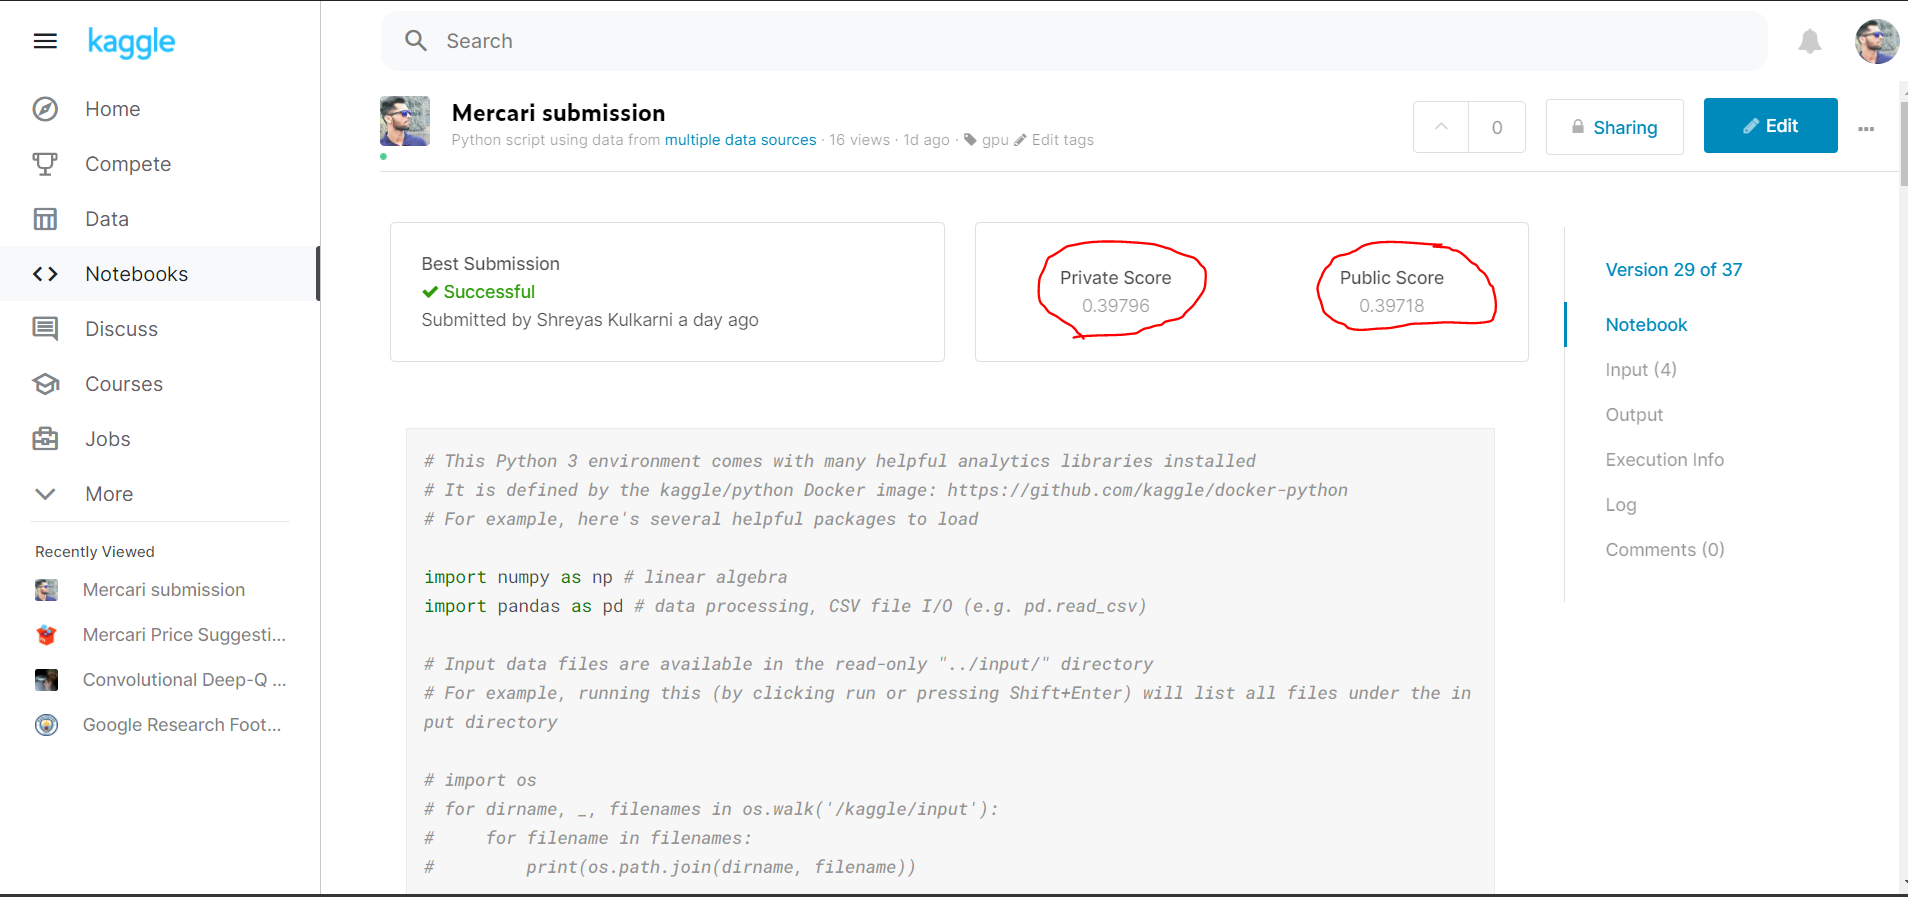

In [ ]:
#My score comes in top 1%

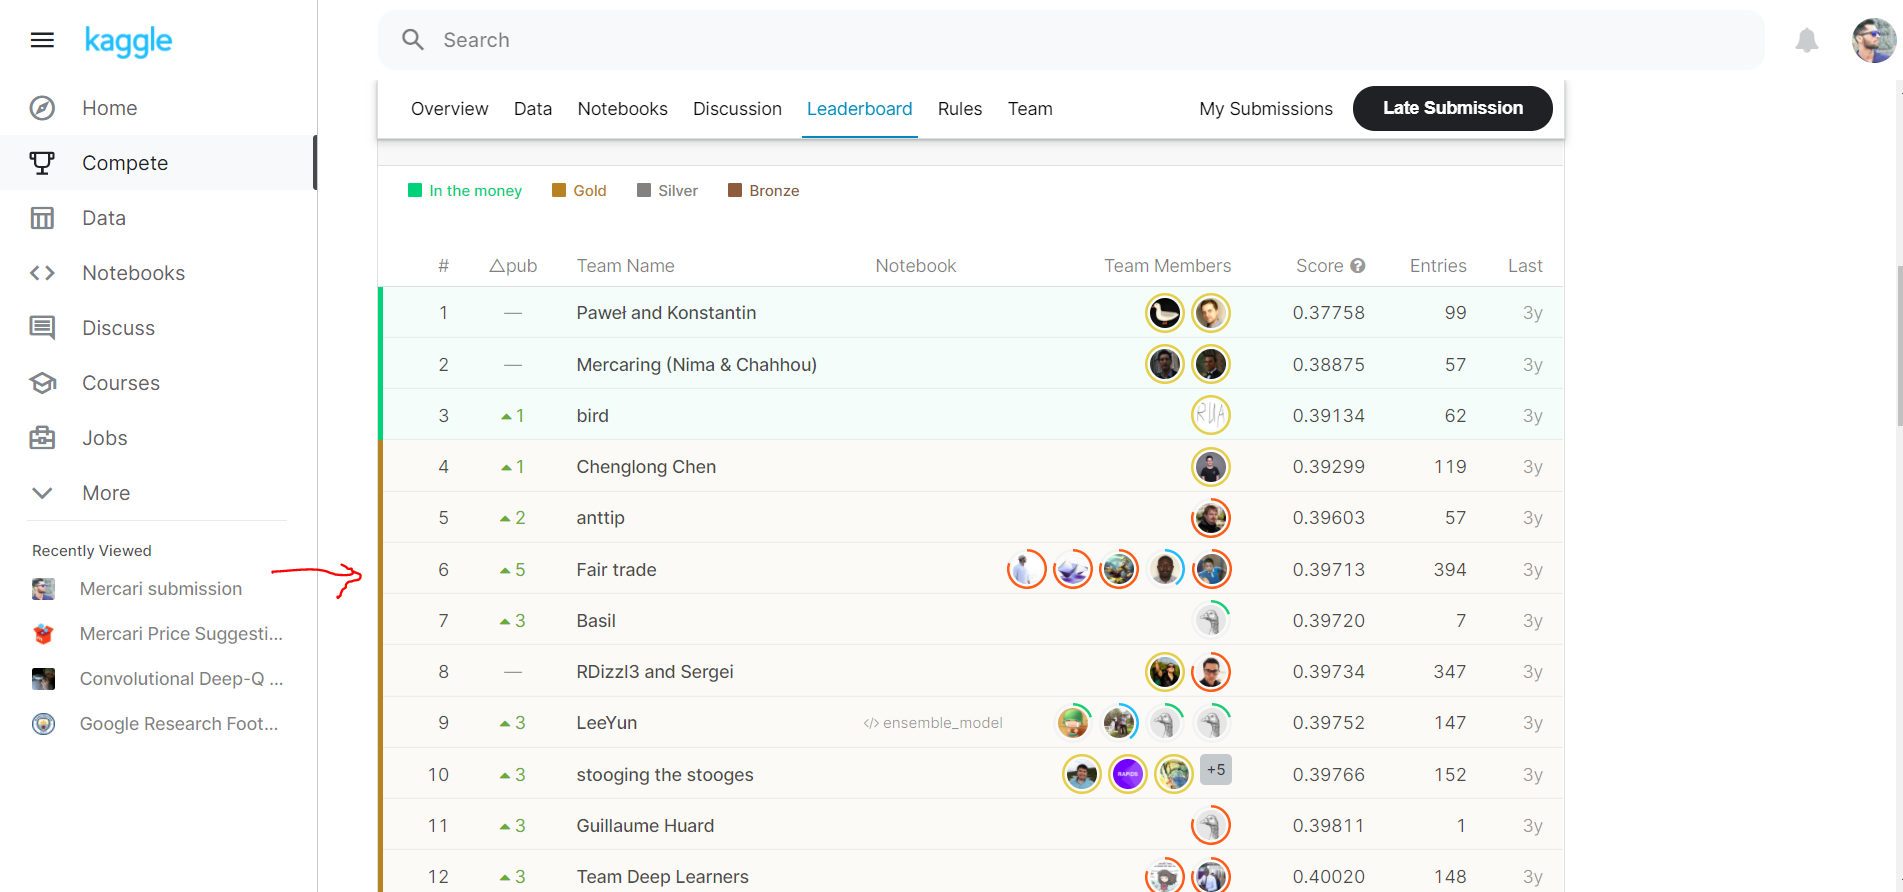

Final function

In [ ]:
"""
This block will go in flask. So we can serve API calls from clients
"""


def imputation(data):

  """
  Fill the missing values
  """
  data.category_name.fillna(value = "other/other/other", inplace = True)
  data.brand_name.fillna(value = "unknown", inplace = True)
  data.item_description.fillna(value = "no_description", inplace = True)
  return data
# pre-process shipping

def pre_shipping(df):
  """
  This function takes df as input and converts shipping column into csr matrix and returns that
  i/p= Whole Dataframe
  o/p= Shipping coloumn in csr matrix format
  o/p shape = (?,1)
  """
  shipping = np.array(df['shipping'])
  shipping = shipping.reshape(-1,1)
  shipping = csr_matrix(shipping)

  return shipping


def pre_item_condition_id(df,vectorizer=None,train=True):

  """
  This function is to pre-process item_condition_id column. We apply One hot encoding on item_condition_id column
  i/p= whole Dataframe
  o/p = OneHotEncoded csr matrix of item_condition_id column
  o/p shape = (?,5)
  """
  if train==True:
    item_condition = np.array(df['item_condition_id']).reshape(-1,1)
    item_condition_vec = OneHotEncoder()
    item_condition_vec.fit(item_condition)
    item_condition = csr_matrix(item_condition_vec.transform(item_condition))

    return item_condition,item_condition_vec
  else:
    item_condition = np.array(df['item_condition_id']).reshape(-1,1)
    item_condition = csr_matrix(vectorizer.transform(item_condition))
    return item_condition


#pre-process category_name

def pre_cat(df,main_cat_vec=None,subcat1_vec=None,subcat2_vec=None,training=True):
  """
  This function does the pre-processing of category_name variable. We first split this variable into 3 parts main category, sub category1 and subcategory 2
  One this new 3 columns One Hot encoding is appiled. Then all 3 a combined together and returend as output.
  df = Whole datfarme 
  main_cat_vec = Vectorizer for main category required during test time
  subcat1_vec =  Vectorizer for sub category1 required during test time
  subcat2_vec =  Vectorizer for sub category2 required during test time
  o/p = csr matrix of One hot encodeding of all 3 coloumn
  o/p shape = (?,973)
  """

  def pre_cat_name(x):
    """
    This function is used to pre-process the text.
    """
    x = str(x).lower()
    x = re.sub('[^A-Za-z0-9]+', ' ', x)
    x = re.sub(' +', ' ', x)
    x = x.replace(' ','_')
    return x

  def pre_item_condition_id(df,vectorizer=None,training=True):
    """
    This function returns the onehot encoded featuers.
    """
    if training==True:
      item_condition = df
      item_condition_vec = CountVectorizer(lowercase=False)
      item_condition_vec.fit(item_condition)
      item_condition = csr_matrix(item_condition_vec.transform(item_condition))

      return item_condition,item_condition_vec
    else:
      item_condition = df
      item_condition = csr_matrix(vectorizer.transform(item_condition))
      return item_condition

  train = df
  train["main_cat"] = train.category_name.str.extract("([^/]+)/[^/]+/[^/]+")
  train["subcat1"] = train.category_name.str.extract("[^/]+/([^/]+)/[^/]+")
  train["subcat2"] = train.category_name.str.extract("[^/]+/[^/]+/([^/]+)")
  train["main_cat"]  = train["main_cat"].apply(pre_cat_name)
  train["subcat1"]  = train["subcat1"].apply(pre_cat_name)
  train["subcat2"]  = train["subcat2"].apply(pre_cat_name)

  if training==True:
    main_cat, main_cat_vec  = pre_item_condition_id(train["main_cat"] )
    subcat1,subcat1_vec = pre_item_condition_id(train["subcat1"] )
    subcat2,subcat2_vec = pre_item_condition_id(train["subcat2"] )
    cat = hstack([main_cat,subcat1,subcat2])

    return cat,main_cat_vec,subcat1_vec,subcat2_vec
  else:
    main_cat  = pre_item_condition_id(train["main_cat"],main_cat_vec,training )
    subcat1 = pre_item_condition_id(train["subcat1"] ,subcat1_vec,training)
    subcat2 = pre_item_condition_id(train["subcat2"] ,subcat2_vec,training)
    cat = hstack([main_cat,subcat1,subcat2])

    return cat

def text_pre(data,tf_idf_vect=None,vec_type=None,training=True):

  """
  This function is to pre-process textual data and return TF-IDF vectorized output. 
  Here we combine name,barnd name and item description and convert it to single column.
  i/p = data with name,barnd name and item description  as input column
  o/p = TF-IDF vectorize output
  shape = (?,200000)
  """
  stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
          "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
          'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
          'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
          'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
          'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
          'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
          'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
          'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
          'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
          's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
          've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
          "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
          "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
          'won', "won't", 'wouldn', "wouldn't"])


  #ps = PorterStemmer() #create object of porterstemmer

  def decontracted(phrase):
    """
    This function is used for doing basic cleaning of sentences.
    i/p = string (sentence)
    o/p = string (clean sentence)
    """

    phrase = re.sub(r"won't", "will not", phrase) # expansion of word won't to will not
    phrase = re.sub(r"can\'t", "can not", phrase)

    phrase =  re.sub(r"http\S+", "", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = phrase.replace(':)', 'smiley').replace('(:', 'smiley').replace(':-)', 'smiley') # replace emojis with word smiley

    phrase = str(phrase).lower()# convert everything to lower
    phrase = re.sub('[^A-Za-z]+', ' ', phrase)# just keep alphabehets remove numbers and other unwanted chars
    phrase = re.sub(' +', ' ', phrase)# remove extra spaces

    phrase = ' '.join(e for e in phrase.split() if e not in stopwords)#remove stopwords
    #phrase = ' '.join(ps.stem(e) for e in phrase.split())#stemming of sentence

    return phrase

  df = data

  df['text'] = df['name'] + " " + df['brand_name'] + " " + df['item_description']

  df['text'] = df['text'].swifter.apply(decontracted)

  if training==True:
    if vec_type=='BOW':
      tf_idf_vect = CountVectorizer(ngram_range=(1,2), min_df=5,max_features=100000,dtype = np.float32)
    if vec_type=='tf-idf':
      tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5,max_features=100000,dtype = np.float32)

    tf_idf_vect.fit(df['text'])
    final_tf_idf = tf_idf_vect.transform(df['text'])

    return final_tf_idf , tf_idf_vect
  else:
    final_tf_idf = tf_idf_vect.transform(df['text'])
  return final_tf_idf

def num_feature(df,vectorizer_nums=None,scale=None,training=True):
  """
  After some EDA and manually reviewing textual data I found out that there was lot of numerical information avaliable in text eg. 10ml , 2 packs, 10 lipsticks 512gb.
  This numerical data had impact on the price of item. So this a function does numerical vectorization of this data.So we first find patterns like (10ml,160gb 2 packs..etc)
  So now we have sentence "250ml 2 packs of xyz company" so here in "ml" column we had "250" and in packs column we add "2".At the end a sparse matrix is given out as output 
  """


  def get_featuers(phrase):
    """
    this function finds all possible numercial patterns in training data and accordingly updates the dictionary.
    """
    phrase = str(phrase).lower()
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)

    nums = re.findall('[0-9]+.[A-Za-z]+',phrase)

    if len(nums)>0:
      for i in nums:
        a =  ''.join(re.findall('[A-Za-z]+',i))
        dic[a] = 0
    else:
      dic['no_data']=0

    return None

  def number(phrase): 
    """
    Finds all patterns and returns dictionary. eg {"ml":10,"gb":512},{"key(pattern)":"value(quantity)"}
    """
    send = dict()
    phrase = str(phrase).lower()
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)

    nums = re.findall('[0-9]+.[A-Za-z]+',phrase)

    if len(nums)>0:
      for z in nums:
        a =  ''.join(re.findall('[A-Za-z]+',z))
        b =  ''.join(re.findall(r'\d+',z))
        b = int(b)
        send[a] = b
    else:
      send['no_data']=1

    return send

  def get_matrix(temp,dic):
    """
    This function is used to generate a csr matrix for numrecial vectorization
    """
    row_ind = []
    col_ind = []
    data = []
    row=0
    for i in temp:
      for z in i:
        if z in dic:
          col = dic[z]
          data_temp = i[z]
          row_ind.append(int(row))
          col_ind.append(int(col))
          data.append(int(data_temp))
      row+=1

    row_ind = np.array(row_ind,dtype=int)

    col_ind = np.array(col_ind,dtype=int)

    data = np.array(data,dtype=float)      

    matrix = csr_matrix((data, (row_ind, col_ind)), shape=(df.shape[0],len(dic)))

    return matrix


  if training==True:
    dic = dict()
    df['text'] = df['name'] + " " + df['item_description']
    df['text'].swifter.apply(get_featuers)
    c=0
    for i in dic:
      dic[i] = c
      c+=1

    temp = df['text'].apply(number)

    matrix = get_matrix(temp,dic)

    scaler = MaxAbsScaler(copy=False)
    scaler.fit(matrix)
    matrix = scaler.transform(matrix)

    return matrix,dic,scaler

  else:
    df['text'] = df['name'] + " " + df['item_description']
    temp = df['text'].swifter.apply(number)

    matrix = get_matrix(temp,vectorizer_nums)

    matrix = scale.transform(matrix)

    return matrix



def mlp_1():
  tf.keras.backend.clear_session() 

  model_in = Input(shape=(128160,), dtype='float32', sparse=True)

  out = Dense(256, activation='tanh')(model_in)
  out = Dropout(0.25)(out)
  out = Dense(124, activation='tanh')(out)
  out = Dense(64, activation='tanh')(out)
  out = Dense(64, activation='tanh')(out)
  out = Dense(32, activation='tanh')(out)
  model_out = Dense(1)(out)
  model = Model(model_in, model_out)
  return model

def mlp_2():
  tf.keras.backend.clear_session() 
  model_in = Input(shape=(128160,), dtype='float32', sparse=True)
  out = Dense(512, activation='tanh')(model_in)
  out = Dropout(0.25)(out)
  out = Dense(64, activation='tanh')(out)
  out = Dense(1)(out)
  model = Model(model_in, out)
  return model



pkl_filename = '/content/drive/My Drive/AAIC/CS/item_condition_vec.pkl'
with open(pkl_filename, 'rb') as file:
    item_condition_vec = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/main_cat_vec.pkl'

with open(pkl_filename, 'rb') as file:
    main_cat_vec = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/subcat1_vec.pkl'

with open(pkl_filename, 'rb') as file:
    subcat1_vec = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/subcat2_vec.pkl'


with open(pkl_filename, 'rb') as file:
    subcat2_vec = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/vec_text_tfidf.pkl'

with open(pkl_filename, 'rb') as file:
    vectorizer_text = pickle.load(file)


pkl_filename = '/content/drive/My Drive/AAIC/CS/vectorizer_nums.pkl'


with open(pkl_filename, 'rb') as file:
    vectorizer_nums = pickle.load(file)


pkl_filename = '/content/drive/My Drive/AAIC/CS/scaler_num.pkl'


with open(pkl_filename, 'rb') as file:
    scaler_num = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/lgbm_model.pkl'


with open(pkl_filename, 'rb') as file:
    lgbm = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/sgr_model.pkl'


with open(pkl_filename, 'rb') as file:
    sgr = pickle.load(file)

pkl_filename = '/content/drive/My Drive/AAIC/CS/y_scaler.pkl'
with open(pkl_filename, 'rb') as file:
    y_scaler = pickle.load(file)

mlp1 = mlp_1()
mlp1.load_weights('/content/drive/My Drive/AAIC/CS/mlp1.h5')


mlp2 = mlp_2()
mlp2.load_weights('/content/drive/My Drive/AAIC/CS/mlp2.h5')




def predict(data):


  X_test = pd.DataFrame(data,index=[0])
  X_test = imputation(X_test)

  X_test_shipping =  pre_shipping(X_test)

  X_test_item_condition = pre_item_condition_id(X_test,item_condition_vec,train=False)


  X_test_cat = pre_cat(X_test,main_cat_vec,subcat1_vec,subcat2_vec,training=False)


  X_test_text = text_pre(X_test,vectorizer_text,training=False)



  X_test_num = num_feature(X_test,vectorizer_nums,scaler_num,training=False)


  X_test = hstack([X_test_shipping,X_test_item_condition,X_test_cat,X_test_text,X_test_num]).tocsr().astype('float32')

  y_lgbm = lgbm.predict(X_test)
  y_sgr = sgr.predict(X_test)
  y_mlp1 = mlp1.predict(X_test)
  y_mlp2 = mlp2.predict(X_test)

  y_final = (y_lgbm + y_sgr + y_mlp1 +y_mlp2)/4
  send = np.expm1(y_scaler.inverse_transform(y_final.reshape(-1, 1))[:, 0])

  return send

In [ ]:
i = 14
input = {"name":df.name[i],
     "item_condition_id":df.item_condition_id[i],
     "category_name":df.category_name[i],
     "brand_name":df.brand_name[i],
     "shipping":df.shipping[i],
     "item_description":df.item_description[i]}

In [ ]:
print('name:',input['name'])
print('item_condition_id:',input['item_condition_id'])
print('category_name:',input['category_name'])
print('brand_name:',input['brand_name'])
print('shipping:',input['shipping'])
print('item_description:',input['item_description'])

name: HOLD for Dogs2016 Minnetonka boots
item_condition_id: 3
category_name: Women/Shoes/Boots
brand_name: UGG Australia
shipping: 0
item_description: Authentic. Suede fringe boots. Great condition! Size 7. If you are between the sizes 5.5-7 and love wearing thick socks during the winter they'd be perfect for you as well (I did last winter) :)


In [ ]:

ans = predict(input)

In [ ]:
print('Original price is ',df.price[i])
print('Predicted price is ',round(ans[0],2))

Original price is  43.0
Predicted price is  55.27


In [ ]:
"""
If we sample some random points we can see that prices are close to original price.So we can say that we have a 
good first cut model.
"""